In [35]:
import numpy as np
import pprint
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import advertools as adv
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
import seaborn as sns

In [36]:
langs = ["nl", "da", "de", "it", "es", ]

model = LinearSVC(max_iter=5000, random_state=21, C=1,  penalty="l1", dual=False, class_weight="balanced")

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])

tfidf = TfidfVectorizer(sublinear_tf=True, encoding='latin-1', ngram_range=(2, 3))

ans = pd.DataFrame()


def simpleModel(X_train, y_train, X_test):
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    X = tfidf.fit_transform(list(X_train) + list(X_test))
    model.fit(X[:len(X_train)], y_train)
    res = model.predict(X[len(X_train):])
    return res


In [37]:
for language in langs:
    print("working on:", language)
    train_data = pd.read_csv(f"../corpus/train/{language}/{language}_plain.csv")
    test_data = pd.read_csv(f"../corpus/test/{language}/{language}_plain.csv")

    res = simpleModel(train_data.text, train_data.label, test_data.text)

    test_data["label"] = res
    test_data = test_data.drop("text", axis=1)
    ans = pd.concat([ans, test_data])
    
results = ans.copy()


working on: nl
Train size: 8313, Test size: 2772
working on: da
Train size: 8314, Test size: 2772
working on: de
Train size: 8313, Test size: 2772
working on: it
Train size: 8314, Test size: 2772
working on: es
Train size: 8314, Test size: 2772


In [38]:
ans["index"] += 1
ans = ans.sort_values(by=["index"])
ans = ans.rename(columns={"index": "id"})
print(ans.head())
ans.to_csv("../submissions/SVM.csv",index=False)

   id     label
0   1   England
0   2   England
1   3   England
0   4   England
1   5  Scotland


In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=21)

results = []
actual = []
overall_acc = []
overall_f1 = []
for language in langs:
    print("working on:", language)
    train = pd.read_csv(f"../corpus/train/{language}/{language}_plain.csv")
    acc = []
    f1 = []
    for train_index, test_index in kfold.split(train):
        X_train, X_test = train.text[train_index], train.text[test_index]
        y_train, y_test = list(train.label[train_index]), list(train.label[test_index])

        res = simpleModel(X_train, y_train, X_test)

        acc.append(accuracy_score(res, y_test))
        f1.append(f1_score(res, y_test, average="weighted"))
        results.extend(res)
        actual.extend(y_test)

    overall_acc.extend(acc)
    overall_f1.extend(f1)

    print(acc)
    print("Acc:", np.array(acc).mean())
    print(f1)
    print("F1:", np.array(f1).mean())

print("\nOverall Acc:", np.array(overall_acc).mean())
print("Overall F1:", np.array(overall_f1).mean())


working on: nl
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6651, Test size: 1662
Train size: 6651, Test size: 1662
[0.666867107636801, 0.6873120865904991, 0.671677690920024, 0.6847172081829122, 0.694344163658243]
Acc: 0.6809836513976959
[0.6846959131893765, 0.705692766244013, 0.6885424325948608, 0.6993549841547142, 0.7102404391474175]
F1: 0.6977053070660764
working on: da
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6651, Test size: 1663
Train size: 6652, Test size: 1662
[0.6542393265183404, 0.6458208057727, 0.6289837642814191, 0.6488274203247144, 0.6865222623345367]
Acc: 0.6528787158463422
[0.6706026213553679, 0.6618345079547454, 0.6433324823756479, 0.6659886806138589, 0.6970343076949423]
F1: 0.6677585199989126
working on: de
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6650, Test size: 1663
Train size: 6651, Test

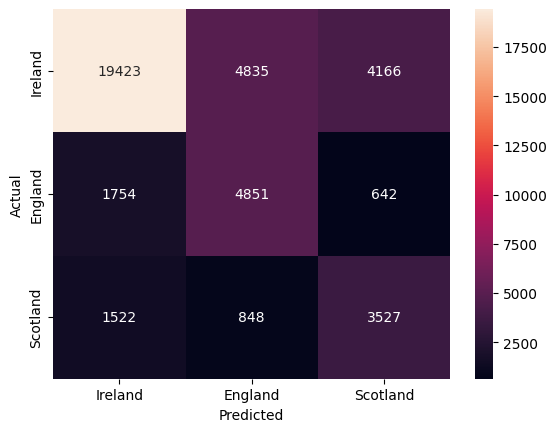

In [40]:
conf_mat = confusion_matrix(results, actual)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=train.label.unique(), yticklabels=train.label.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
